# H02C8b Information Retrieval and Search Engines: RAG Project

Welcome to the notebook companion for the IRSE project. You will find all starter code here. You are encouraged to use this code, as it has been confirmed to work for the RAG pipeline described in the assignment handout. However, you are certainly welcome to make any changes you see fit, provided that your code is written in Python and runs without issue.

**IMPORTANT**: Do not submit a notebook as your final solution. It will not be graded. Refer to assignment handout for more information about the submission format.

**IMPORTANT**: Be mindful of your runtime usage, if working in Colab. At the beginning of every session, navigate to the top menu bar in Colab and select **Runtime > Change runtime type > CPU (Python 3)**. This will ensure that your session runs on CPU and that you do not waste any GPU allocation for the day. GPUs are provided by Google on a limited daily basis, and access is given every 24 hours. It is best that you complete the TF-IDF/search component before loading models and running inference on the GPU runtime.


If you have any questions, feel free to email [Thomas](mailto:thomas.bauwens@kuleuven.be) or [Kushal](mailto:kushaljayesh.tatariya@kuleuven.be).

## RAG for recipe recommendation:

We will begin by installing the huggingface `datasets` library for easily loading our data.

In [1]:
# ! pip -q install datasets
# !wget https://people.cs.kuleuven.be/~thomas.bauwens/irse_documents_2025_recipes.parquet
# !wget https://people.cs.kuleuven.be/~thomas.bauwens/irse_queries_2025_recipes.json


In [16]:
import json
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import math
import numpy as np
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool, cpu_count
from functools import partial
from tqdm import tqdm
import string
from nltk.tokenize import word_tokenize
import datasets
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from scipy.sparse import hstack
tqdm.pandas()  # Show progress bar if using pandas
import time
import nltk
from utils import *
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("punkt_tab")
nltk.download("wordnet")

# from google.colab import userdata
# userdata.get("HF_TOKEN")

[nltk_data] Downloading package punkt to /home/yan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/yan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/yan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/yan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/yan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import time


def calculate_average_precision(relevant_doc_ids, retrieved_doc_ids):
    hit_count = 0
    sum_precisions = 0.0
    for i, doc_id in enumerate(retrieved_doc_ids):
        if doc_id in relevant_doc_ids:
            hit_count += 1
            precision_at_i = hit_count / (i + 1)
            sum_precisions += precision_at_i

    if len(relevant_doc_ids) == 0:
        return 0.0

    return sum_precisions / len(relevant_doc_ids)


def calculate_mean_average_precision(all_relevant_doc_ids, all_retrieved_doc_ids):
    average_precisions = []
    for relevant, retrieved in zip(all_relevant_doc_ids, all_retrieved_doc_ids):
        ap = calculate_average_precision(relevant, retrieved)
        average_precisions.append(ap)

    return {
        "map": (
            sum(average_precisions) / len(average_precisions)
            if average_precisions
            else 0.0
        )
    }


def calculate_precision_recall_f1_optimized(relevant_doc_ids, retrieved_doc_ids):
    relevant_set = set(relevant_doc_ids)
    retrieved_set = set(retrieved_doc_ids)
    true_positives = len(relevant_set.intersection(retrieved_set))

    if len(retrieved_set) == 0:
        precision = 0.0
        recall = 0.0 if len(relevant_set) > 0 else 1.0
        f1 = 0.0
    elif len(relevant_set) == 0:
        precision = 0.0
        recall = 0.0
        f1 = 0.0
    else:
        precision = true_positives / len(retrieved_set)
        recall = true_positives / len(relevant_set)
        if precision + recall > 0:
            f1 = 2 * precision * recall / (precision + recall)
        else:
            f1 = 0.0

    return {"precision": precision, "recall": recall, "f1": f1}


def calculate_macro_averages(metrics_per_query):
    precision_values = [metrics["precision"] for metrics in metrics_per_query]
    recall_values = [metrics["recall"] for metrics in metrics_per_query]
    f1_values = [metrics["f1"] for metrics in metrics_per_query]

    macro_precision = np.mean(precision_values)
    macro_recall = np.mean(recall_values)
    macro_f1 = np.mean(f1_values)

    return {
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "macro_f1": macro_f1,
    }


def calculate_micro_averages_optimized(all_relevant_doc_ids, all_retrieved_doc_ids):
    all_relevant = [
        doc_id for query_relevant in all_relevant_doc_ids for doc_id in query_relevant
    ]
    all_retrieved = [
        doc_id
        for query_retrieved in all_retrieved_doc_ids
        for doc_id in query_retrieved
    ]

    relevant_set = set(all_relevant)
    retrieved_set = set(all_retrieved)
    true_positives = len(relevant_set.intersection(retrieved_set))

    if len(retrieved_set) == 0:
        micro_precision = 0.0
        micro_recall = 0.0 if len(relevant_set) > 0 else 1.0
        micro_f1 = 0.0
    elif len(relevant_set) == 0:
        micro_precision = 0.0
        micro_recall = 1.0
        micro_f1 = 0.0
    else:
        micro_precision = true_positives / len(retrieved_set)
        micro_recall = true_positives / len(relevant_set)
        if micro_precision + micro_recall > 0:
            micro_f1 = (
                2 * micro_precision * micro_recall / (micro_precision + micro_recall)
            )
        else:
            micro_f1 = 0.0

    return {
        "micro_precision": micro_precision,
        "micro_recall": micro_recall,
        "micro_f1": micro_f1,
    }


# Define the evaluation function outside of the main function so it can be pickled
def evaluate_combination(combo, queries, recipes, recipe_ids, k_values, thresholds):
    i, j = combo
    k = k_values[i]
    threshold = thresholds[j]

    metrics = evaluate_ir_system(
        queries, recipes, recipe_ids, k=int(k), threshold=threshold
    )

    return (i, j, metrics["macro_f1"])


def create_parameter_heatmap(queries, recipes, recipe_ids):
    thresholds = np.arange(0.1, 0.25, 0.04)
    k_values = np.arange(10, 50, 3)
    total_combinations = len(k_values) * len(thresholds)
    f1_matrix = np.zeros((len(k_values), len(thresholds)))

    # Create all parameter combinations
    combinations = [
        (i, j) for i in range(len(k_values)) for j in range(len(thresholds))
    ]

    # Set up partial function with fixed parameters
    evaluate_func = partial(
        evaluate_combination,
        queries=queries,
        recipes=recipes,
        recipe_ids=recipe_ids,
        k_values=k_values,
        thresholds=thresholds,
    )

    # Determine number of processes (use fewer if there aren't many combinations)
    num_processes = min(cpu_count(), total_combinations)

    # Execute in parallel
    print(f"Running parameter search using {num_processes} processes...")
    with Pool(processes=num_processes) as pool:
        results = list(
            tqdm(
                pool.imap(evaluate_func, combinations),
                total=total_combinations,
                desc="Evaluating combinations",
            )
        )

    # Fill in the results matrix
    for i, j, f1_score in results:
        f1_matrix[i, j] = f1_score

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        f1_matrix,
        annot=True,
        fmt=".3f",
        cmap="YlGnBu",
        xticklabels=[f"{t:.2f}" for t in thresholds],
        yticklabels=[f"{int(k)}" for k in k_values],
    )

    plt.title("Macro F1 Scores for Combinations of k and Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("k")
    plt.tight_layout()
    plt.savefig(f"ir_parameter_heatmap{int(time.time())}.png", dpi=300)
    plt.show()

    # Find the best combination
    best_i, best_j = np.unravel_index(f1_matrix.argmax(), f1_matrix.shape)
    best_k = k_values[best_i]
    best_threshold = thresholds[best_j]
    best_f1 = f1_matrix[best_i, best_j]

    print(f"\nBest parameter combination:")
    print(f"k = {int(best_k)}, threshold = {best_threshold:.2f}")
    print(f"Macro F1 = {best_f1:.4f}")

    return {
        "f1_matrix": f1_matrix,
        "best_k": int(best_k),
        "best_threshold": best_threshold,
        "best_f1": best_f1,
    }


def retrieve_documents(query_text, recipies, recipe_ids, k, threshold):
    if len(recipies) != len(recipe_ids):
        raise ValueError("Recipes and recipe_ids must have the same length")
    if k is None and threshold is None:
        raise ValueError("Either k or threshold must be specified")

    q_uni = vec_uni.transform([query_text])
    q_bi = vec_bi.transform([query_text])
    q_all = hstack([q_uni, q_bi])

    X_all = hstack([X_uni, X_bi])

    cosine_similarities = cosine_similarity(q_all, X_all).flatten()
    euclidean_dis = euclidean_distances(q_all, X_all).flatten()

    # results = [
    #     (recipies[i], recipe_ids[i], 1 / (1+euclidean_dis[i]))
    #     for i in range(len(recipies))
    # ]

    results = [
        (recipies[i], recipe_ids[i], cosine_similarities[i])
        for i in range(len(recipies))
    ]
    results.sort(key=lambda x: x[2], reverse=True)

    if threshold is not None:
        results = [r for r in results if r[2] >= threshold]

    if k is not None:
        results = results[:k]
    # print(results[0][2] ,"||", results[1][2])
    return results


def evaluate_ir_system(queries, recipies, recipe_ids, k, threshold):
    metrics_per_query = []
    all_relevant_doc_ids = []
    all_retrieved_doc_ids = []

    for _, row in tqdm(queries.iterrows()):
        query_text = row["q"]
        relevant_doc_ids = [doc[0] for doc in row["r"]]

        results = retrieve_documents(query_text, recipies, recipe_ids, k, threshold)
        retrieved_doc_ids = [result[1] for result in results]
        # TODO: understand how its calcualted
        query_metrics = calculate_precision_recall_f1_optimized(
            relevant_doc_ids, retrieved_doc_ids
        )
        metrics_per_query.append(query_metrics)

        all_relevant_doc_ids.append(relevant_doc_ids)
        all_retrieved_doc_ids.append(retrieved_doc_ids)
    # TODO: understand how its calcualted

    macro_metrics = calculate_macro_averages(metrics_per_query)
    micro_metrics = calculate_micro_averages_optimized(
        all_relevant_doc_ids, all_retrieved_doc_ids
    )
    MAP_metric = calculate_mean_average_precision(
        all_relevant_doc_ids, all_retrieved_doc_ids
    )

    all_metrics = {**macro_metrics, **micro_metrics, **MAP_metric}
    return all_metrics


In [4]:
dataset = datasets.load_dataset(
    "parquet", data_files="./irse_documents_2025_recipes.parquet"
)["train"]
queries_data = json.load(open("./irse_queries_2025_recipes.json", "r"))

df = dataset.to_pandas()

recipies = df.apply(
    lambda row: f"{row['name']} {row['description']} {row['ingredients']} {row['steps']}",
    axis=1,
)
recipe_ids = dataset["official_id"]
print("Number of documents:", len(recipies))

queries = pd.DataFrame(columns=["q", "r", "a"])
for query_item in queries_data["queries"]:
    query_text = query_item["q"]
    relevance_pairs = query_item["r"]
    answer = query_item["a"]
    queries = pd.concat(
        [
            queries,
            pd.DataFrame({"q": [query_text], "r": [relevance_pairs], "a": [answer]}),
        ],
        ignore_index=True,
    )

print("Number of queries:", len(queries))

Number of documents: 231637
Number of queries: 47


In [5]:
stop_words = set(stopwords.words("english"))
stop_words.update(
    [
        "add",
        "added",
        "adding",
        "addition",
        "also",
        "almost",
        "another",
        "easily",
        "easy",
    ]
)
lemmatizer = WordNetLemmatizer()


def preprocess_vocabulary(doc):
    doc = doc.translate(str.maketrans("", "", string.punctuation)).lower()

    words = word_tokenize(doc)

    words = [
        lemmatizer.lemmatize(word)
        for word in words
        if word not in stop_words and word.isalpha()
    ]

    return " ".join(words)


import os
import pickle

filename = "preprocessed_recipes.pkl"
if os.path.exists(filename):
    with open(filename, "rb") as f:
        preprocessed_recipes = pickle.load(f)
else:
    preprocessed_recipes = [preprocess_vocabulary(doc) for doc in tqdm(recipies)]
    with open(filename, "wb") as f:
        pickle.dump(preprocessed_recipes, f)  # Adjust based on the format used


#### Preprocessor

In [6]:
vec_uni = TfidfVectorizer(min_df=20, max_df=0.5, ngram_range=(1, 1))
vec_bi = TfidfVectorizer(
    min_df=10,
    max_df=0.3,
    ngram_range=(2, 2),
    max_features=20000,
)

X_uni = vec_uni.fit_transform(preprocessed_recipes)
X_bi = vec_bi.fit_transform(preprocessed_recipes)


In [7]:
vocab_uni = vec_uni.get_feature_names_out()
idf_values_uni = vec_uni.idf_

sorted_terms_uni = sorted(list(zip(vocab_uni, idf_values_uni)), key=lambda x: x[1], reverse=True)

sorted_terms_uni

[('agaragar', np.float64(10.308408649491652)),
 ('agrees', np.float64(10.308408649491652)),
 ('ainsley', np.float64(10.308408649491652)),
 ('ajwain', np.float64(10.308408649491652)),
 ('akin', np.float64(10.308408649491652)),
 ('ali', np.float64(10.308408649491652)),
 ('alow', np.float64(10.308408649491652)),
 ('ambitious', np.float64(10.308408649491652)),
 ('ancestor', np.float64(10.308408649491652)),
 ('angled', np.float64(10.308408649491652)),
 ('antique', np.float64(10.308408649491652)),
 ('aparts', np.float64(10.308408649491652)),
 ('applewood', np.float64(10.308408649491652)),
 ('arriving', np.float64(10.308408649491652)),
 ('attracted', np.float64(10.308408649491652)),
 ('augustseptember', np.float64(10.308408649491652)),
 ('aversion', np.float64(10.308408649491652)),
 ('babe', np.float64(10.308408649491652)),
 ('bali', np.float64(10.308408649491652)),
 ('bao', np.float64(10.308408649491652)),
 ('baptist', np.float64(10.308408649491652)),
 ('bavaria', np.float64(10.3084086494916

In [8]:
vocab_bi = vec_bi.get_feature_names_out()
idf_values_bi = vec_bi.idf_

sorted_terms_bi = sorted(list(zip(vocab_bi, idf_values_bi)), key=lambda x: x[1], reverse=True)



bigram_idfs = [idf for _,  idf in sorted_terms_bi]
print(f"\nDo all bigrams have same IDF? {len(set(bigram_idfs))}")
print(f"Number of unique IDF values for bigrams: {len(set(bigram_idfs))}")


Do all bigrams have same IDF? 2217
Number of unique IDF values for bigrams: 2217


In [9]:
sorted_terms_bi

[('banana leaf', np.float64(9.461110789104449)),
 ('cedar plank', np.float64(9.363947040650801)),
 ('meyer lemon', np.float64(9.209796360823542)),
 ('broccoli rabe', np.float64(9.163276345188649)),
 ('rose petal', np.float64(9.133423382038968)),
 ('grape leaf', np.float64(9.118824582617815)),
 ('truffle oil', np.float64(9.118824582617815)),
 ('fish cake', np.float64(9.104435845165716)),
 ('pot sticker', np.float64(9.09025121017376)),
 ('wheat berry', np.float64(9.062471646066683)),
 ('pomegranate molasses', np.float64(9.048865994010905)),
 ('heart palm', np.float64(9.035442973678764)),
 ('celery root', np.float64(9.022197746928745)),
 ('candy corn', np.float64(8.996222260525483)),
 ('custard powder', np.float64(8.983483234748054)),
 ('rack lamb', np.float64(8.983483234748054)),
 ('sushi rice', np.float64(8.983483234748054)),
 ('halibut steak', np.float64(8.970904452541195)),
 ('strawberry rhubarb', np.float64(8.970904452541195)),
 ('fiber one', np.float64(8.958481932542636)),
 ('pastry

#### TF-IDF

In [10]:
from utils import *
best_K=5
best_threshold=None #0.24

In [11]:
# metrics = evaluate_ir_system(queries.iloc[[40,41,42,43,44,45,46]], recipies, recipe_ids, k=best_K, threshold=best_threshold)

# metrics

In [12]:
metrics = evaluate_ir_system(queries, recipies, recipe_ids, k=best_K, threshold=best_threshold)

metrics

47it [01:00,  1.29s/it]


{'macro_precision': np.float64(0.17446808510638295),
 'macro_recall': np.float64(0.07235213012783966),
 'macro_f1': np.float64(0.08702145595914476),
 'micro_precision': 0.20634920634920634,
 'micro_recall': 0.07991803278688525,
 'micro_f1': 0.11521418020679469,
 'map': 0.05955347488237591}

For a given query and set of relevant documents, you are also required to create a prompt that instructs a model to complete a certain task (e.g. recipe recommendation). You should experiment with formatting the prompt, as language models have been shown to be sensitive to the exact verbiage of instructions.

Running parameter search using 8 processes...


47it [02:50,  3.63s/it]:   2%|▏         | 1/50 [02:51<2:19:53, 171.30s/it]
47it [02:50,  3.62s/it]
47it [02:52,  3.67s/it]
47it [02:55,  3.73s/it]
47it [02:51,  3.66s/it]:   4%|▍         | 2/50 [02:55<58:38, 73.30s/it]   
47it [02:54,  3.71s/it]
47it [02:58,  3.80s/it]
47it [02:58,  3.79s/it]:   6%|▌         | 3/50 [02:59<32:36, 41.62s/it]
47it [02:57,  3.77s/it]
47it [02:59,  3.81s/it]
47it [02:58,  3.80s/it]
47it [03:04,  3.92s/it]
47it [03:00,  3.84s/it]:  24%|██▍       | 12/50 [05:58<13:03, 20.62s/it]
47it [03:06,  3.96s/it]
47it [02:49,  3.60s/it]:  30%|███       | 15/50 [06:04<08:20, 14.29s/it]
47it [02:54,  3.72s/it]
47it [02:52,  3.68s/it]:  38%|███▊      | 19/50 [08:47<11:46, 22.78s/it]
47it [02:53,  3.70s/it]
47it [02:51,  3.64s/it]
47it [02:58,  3.80s/it]
47it [02:50,  3.62s/it]:  48%|████▊     | 24/50 [08:57<04:46, 11.03s/it]
47it [02:55,  3.73s/it]
47it [02:52,  3.67s/it]:  52%|█████▏    | 26/50 [11:45<11:15, 28.16s/it]
47it [02:54,  3.70s/it]
47it [02:59,  3.83s/it]
47it 

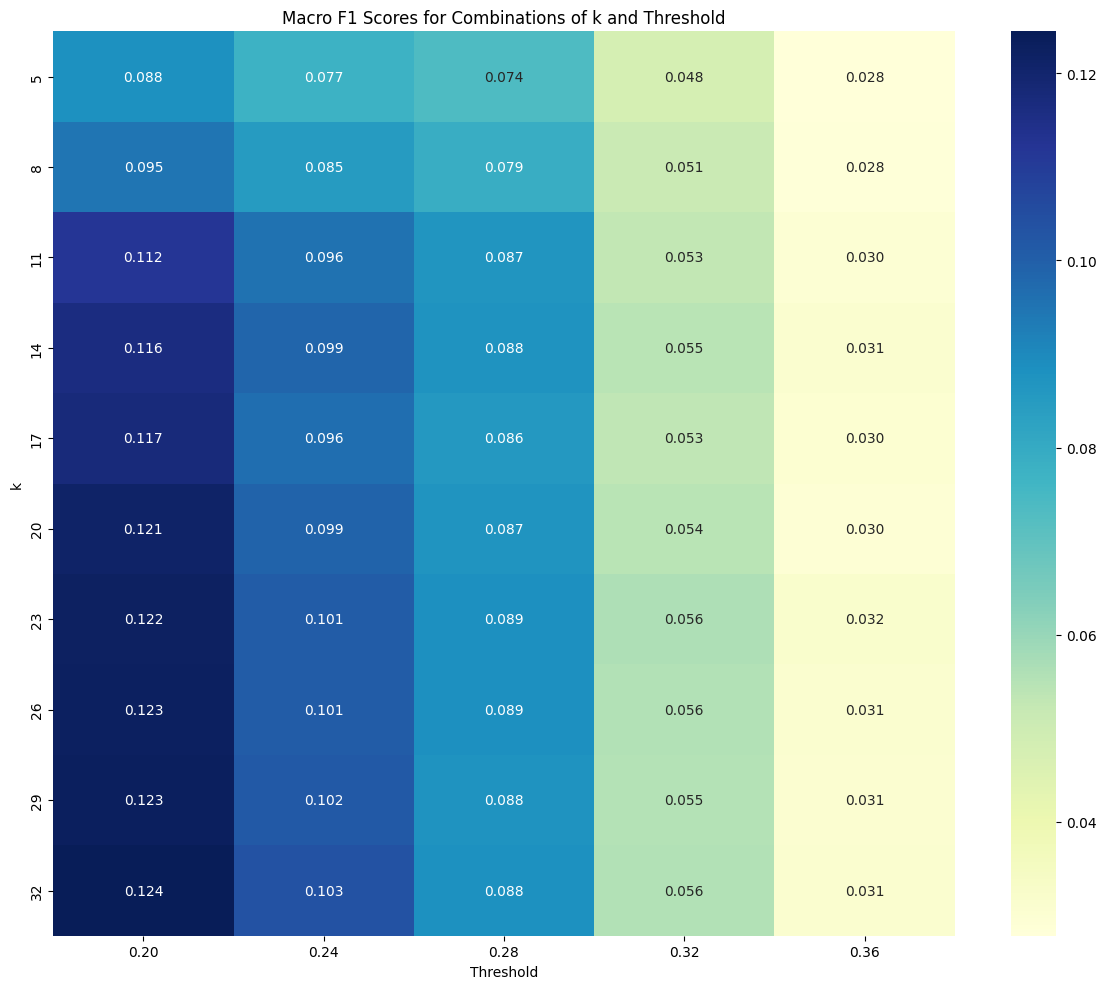


Best parameter combination:
k = 32, threshold = 0.20
Macro F1 = 0.1245


In [13]:
results = create_parameter_heatmap(queries, recipies, recipe_ids)

1744655835

In [ ]:
prompt = """

# Recipe Assistant

## Context
You are a helpful recipe assistant with access to a database of recipes. The system has already retrieved the most relevant recipes to the user's query using TF-IDF similarity. Your goal is to provide helpful, accurate responses about recipes, cooking techniques, ingredient substitutions, and culinary advice based on the retrieved recipes.

## Retrieved Recipes
The following recipes have been retrieved as most relevant to the user's query:

{retrieved_recipes}

## Instructions
1. **Answer directly from the retrieved recipes when possible.** Use the information from the provided recipes to answer questions about ingredients, cooking methods, nutritional information, and preparation steps.

2. **For ingredient questions:**
   - Provide accurate amounts and measurements from the recipes
   - Suggest possible substitutions based on common culinary knowledge
   - Explain the purpose of key ingredients in the dish

3. **For cooking technique questions:**
   - Explain preparation methods mentioned in the recipes
   - Clarify cooking times and temperatures
   - Describe expected results and how to tell when food is properly cooked

4. **For modification requests:**
   - Suggest appropriate adjustments for dietary restrictions (vegan, gluten-free, etc.)
   - Explain how to scale recipes up or down
   - Offer ideas for flavor variations while maintaining the core identity of the dish

5. **For general questions:**
   - Provide brief culinary background/history when relevant
   - Explain unfamiliar cooking terms
   - Suggest pairings, serving suggestions, and storage recommendations

## Response Format
- Start with a direct answer to the user's question
- Keep your responses concise but comprehensive
- For multi-step instructions or complex concepts, organize information in a clear, logical structure
- If the retrieved recipes don't contain sufficient information to answer the query, acknowledge the limitations and provide general culinary knowledge that might help
- When suggesting modifications not explicitly in the retrieved recipes, clearly indicate these are your recommendations based on culinary principles

## Limitations
- Don't make claims about specific nutritional values unless they're mentioned in the retrieved recipes
- If asked about topics completely unrelated to cooking or the recipes provided, politely redirect the conversation back to recipe-related topics
- Don't invent or fabricate details about recipes that aren't in the retrieved data

## User Query
{user_query}
"""

In [ ]:
irrelevant_context = """
Richard Gary Brautigan (January 30, 1935 – c. September 16, 1984)
was an American novelist, poet, and short story writer. A prolific writer,
he wrote throughout his life and published ten novels, two collections of
short stories, and four books of poetry. Brautigan's work has been published
both in the United States and internationally throughout Europe, Japan,
and China. He is best known for his novels Trout Fishing in America (1967),
In Watermelon Sugar (1968), and The Abortion: An Historical Romance 1966 (1971).
"""

**IMPORTANT**: only run the following code when you have implemented a working retrieval system. When you are ready to work with language models, navigate to the menu bar in Colab and select **Runtime > Change runtime type > T4 GPU**. If you find yourself working on not GPU-intenstive tasks in this notebook, change your runtime back to CPU to preserve access.


In [ ]:
! pip -q install git+https://github.com/huggingface/transformers
! pip -q install datasets bitsandbytes accelerate xformers einops

In [ ]:
import torch
import transformers
import numpy as np

from transformers import AutoTokenizer, AutoModelForCausalLM
from google.colab import userdata


In [ ]:
# from huggingface_hub import login

# Replace "YOUR_HF_TOKEN" with your actual Hugging Face token
# login(token=userdata.get("HF_TOKEN"))

The code below will load a Mistral 7B instruct model and quantize it via `bitesandbytes`. Doing so will ensure that the model will not take up too much memory and make inference more efficient. Note that the call to `AutoModelForCausalLM.from_pretrained()` will take a while, as the model's weights must be downloaded from the huggingface hub. Also note that you are not restricted to using Mistral, and are welcome to experiment with other models (though you will have more luck with chat and instruction-tuned variants).

In [ ]:
model_id = "mistralai/Mistral-7B-Instruct-v0.2"
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_id, trust_remote_code=True, quantization_config=bnb_config, device_map="auto"
)

A tokenizer is required in order to convert strings into integer sequences that can be passed as input to the model.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
retrieved_recipes = "1. Chocolate Chip Cookies...\n2. Brownie Bites..."
user_query = "Can I use coconut oil instead of butter in cookies?"

# Fill in the template
input_string_with_context = prompt.format(
    retrieved_recipes=retrieved_recipes, user_query=user_query
)

input_string_without_context = prompt.format(
    retrieved_recipes=irrelevant_context, user_query=user_query
)

In [ ]:
encoded_prompt = tokenizer(
    input_string_with_context, return_tensors="pt", add_special_tokens=False
)
encoded_prompt = encoded_prompt.to("cuda")
generated_ids = model.generate(**encoded_prompt, max_new_tokens=1000, do_sample=True)
decoded = tokenizer.batch_decode(generated_ids)
print(decoded[0])

In [ ]:
encoded_prompt = tokenizer(
    input_string_without_context, return_tensors="pt", add_special_tokens=False
)
encoded_prompt = encoded_prompt.to("cuda")
generated_ids = model.generate(**encoded_prompt, max_new_tokens=1000, do_sample=True)
decoded = tokenizer.batch_decode(generated_ids)
print(decoded[0])